In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dropout, BatchNormalization, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [2]:
os.listdir('./data/preprocessed')

['djia_news_top1_22.csv']

# Data import

In [4]:
# df_reddit = pd.read_csv('../data/stocknews/RedditNews.csv')
df_news = pd.read_csv('./data/preprocessed/djia_news_top1_22.csv')
df_djia = pd.read_csv('./data/stocknews/upload_DJIA_table.csv')


In [5]:
df_news.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22
1984,2016-06-27,0,barclays and rbs shares suspended from trading...,pope says church should ask forgiveness from g...,poland shocked by xenophobic abuse of poles in uk,there will be no second referendum cabinet agrees,scotland welcome to join eu merkel ally says,sterling dips below fridays year low amid brex...,no negative news about south african president...,surge in hate crimes in the uk following uks b...,...,giant panda in macau gives birth to twins,get out now eu leader tells britain it must in...,sea turtle beaten and left for dead on beach b...,german lawyers to probe erdogan over alleged w...,boris johnson says the uk will continue to int...,richard branson is calling on the uk governmen...,turkey sorry for downing russian jet,edward snowden lawyer vows new push for pardon...,brexit opinion poll reveals majority dont want...,conservative mp leave campaigner the leave cam...
1985,2016-06-28,1,scientists to australia if you want to save th...,the personal details of french police officer...,sampp cuts united kingdom sovereign credit rat...,huge helium deposit found in africa,ceo of the south african state broadcaster qui...,brexit cost investors trillion the worst one ...,hong kong democracy activists call for return ...,brexit iceland president says uk can join tria...,...,ryanair will not deploy new aircraft on routes...,people ever more greedy and stupid destroy the...,siemens freezes new uk wind power investment f...,us canada and mexico pledge of power from cle...,there is increasing evidence that australia is...,richard branson the founder of virgin group sa...,yrold skull from borneo reveals surprise for s...,palestinians stone western wall worshipers pol...,jeanclaude juncker asks farage why are you here,romanians for remainians offering a new home t...
1986,2016-06-29,1,explosion at airport in istanbul,yemeni former president terrorism is the offsp...,uk must accept freedom of movement to access e...,devastated scientists too late to captive bree...,british labor party leader jeremy corbyn loses...,a muslim shop in the uk was just firebombed wh...,mexican authorities sexually torture women in ...,uk shares and pound continue to recover,...,former belgian prime minister ridicules nigel ...,brexiteer nigel farage to eu youre not laughin...,islamic state bombings in southern yemen kill ...,escape tunnel dug by hand is found at holocaus...,the land under beijing is sinking by as much a...,car bomb and antiislamic attack on mosque in p...,emaciated lions in taiz zoo are trapped in blo...,rupert murdoch describes brexit as wonderful t...,more than killed in yemen suicide attacks,google found disastrous symantec and norton vu...
1987,2016-06-30,1,jamaica proposes marijuana dispensers for tour...,stephen hawking says pollution and stupidity s...,boris johnson says he will not run for tory pa...,six gay men in ivory coast were abused and for...,switzerland denies citizenship to muslim immig...,palestinian terrorist stabs israeli teen girl ...,puerto rico will default on billion of debt o...,republic of ireland fans to be awarded medal f...,...,japans top court has approved blanket surveill...,cia gave romania millions to host secret prisons,groups urge un to suspend saudi arabia from ri...,googles free wifi at indian railway stations i...,mounting evidence suggests hobbits were wiped ...,the men who carried out tuesdays terror attack...,calls to suspend saudi arabia from un human ri...,more than nobel laureates call out greenpeace...,british pedophile sentenced to years in us fo...,us permitted offshore fracks in gulf of mexic...
1988,2016-07-01,1,a yearold woman in mexico city finally receive...,imf chief backs athens as permanent olympic host,the president of france says if brexit won so ...,british man who must give police hours notice...,nobel laureates urge greenpeace to stop opposi...,brazil huge spi

In [8]:
df = pd.merge(df_djia, df_news, on='Date', how='inner')

# df = pd.merge(df_djia_news, df_reddit, on='Date', how='inner')

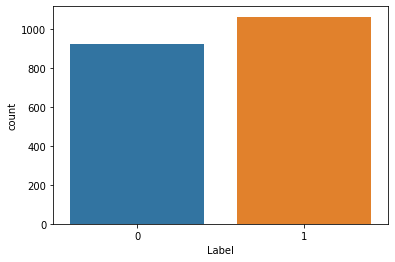

In [9]:
# 0 = decrease , 1 = increase or equal at Adj.Close
sns.countplot(x='Label', data=df_news)

In [10]:
df_news['Date'] = pd.to_datetime(df_news.Date)
train_split = 0.8
total_count = df_news.shape[0]
train_cut = int(total_count * train_split)
train = df_news.loc[:train_cut-1, :]
test = df_news.loc[train_cut:, :]
y_train = np.array(train["Label"])
y_test = np.array(test["Label"])

In [11]:
train.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22
0,2008-08-08,0,georgia downs two russian warplanes as countri...,breaking musharraf to be impeached,russia today columns of troops roll into south...,russian tanks are moving towards the capital o...,afghan children raped with impunity un officia...,russian tanks have entered south ossetia whils...,breaking georgia invades south ossetia russia ...,the enemy combatent trials are nothing but a s...,...,sorussia and georgia are at war and the nyts t...,china tells bush to stay out of other countrie...,did world war iii start today,georgia invades south ossetia if russia gets ...,alqaeda faces islamist backlash,condoleezza rice the us would not act to preve...,this is a busy day the european union has app...,georgia will withdraw soldiers from iraq to h...,why the pentagon thinks attacking iran is a ba...,caucasus in crisis georgia invades south ossetia
1,2008-08-11,1,why wont america and nato help us if they wont...,bush puts foot down on georgian conflict,jewish georgian minister thanks to israeli tra...,georgian army flees in disarray as russians ad...,olympic opening ceremony fireworks faked,what were the mossad with fraudulent new zeala...,russia angered by israeli military sale to geo...,an american citizen living in sossetia blames ...,...,us ship heads for arctic to define territory,drivers in a jerusalem taxi station threaten t...,the french team is stunned by phelps and the x...,israel and the us behind the georgian aggression,do not believe tv neither russian nor georgian...,riots are still going on in montreal canada be...,china to overtake us as largest manufacturer,war in south ossetia pics,israeli physicians group condemns state torture,russia has just beaten the united states over ...
2,2008-08-12,0,remember that adorable yearold who sang at the...,russia ends georgia operation,if we had no sexual harassment we would have n...,alqaeda is losing support in iraq because of a...,ceasefire in georgia putin outmaneuvers the west,why microsoft and intel tried to kill the xo ...,stratfor the russogeorgian war and the balance...,im trying to get a sense of this whole georgia...,...,beginning a war as the olympics were opening v...,pyramids as large as the luxor stacked into a ...,the top party cities in the world,us troops still in georgia did you know they w...,why russias response to georgia was right,gorbachev accuses us of making a serious blund...,russia georgia and nato cold war two,remember that adorable yearold who led your co...,war in georgia the israeli connection,all signs point to the us encouraging georgia ...
3,2008-08-13,0,us refuses israel weapons to attack iran report,when the president ordered to attack tskhinval...,israel clears troops who killed reuters cameraman,britains policy of being tough on drugs is poi...,body of year old found in trunk latest ransom...,china has moved million quake survivors into ...,bush announces operation get all up in russias...,russian forces sink georgian ships,...,in an intriguing cyberalliance two estonian co...,the cnn effect georgia schools russia in infor...,why russias response to georgia was right,elephants extinct by,us humanitarian missions soon in georgia if r...,georgias ddos came from us sources,russian convoy heads into georgia violating truce,israeli defence minister us against strike on ...,gorbachev we had no choice,witness russian forces head towards tbilisi in...
4,2008-08-14,1,all the experts admit that we should legalise ...,war in south osetia pictures made by a russi...,swedish wrestler ara abrahamian throws away me...,russia exaggerated the death toll in south oss...,missile that killed inside pakistan may have ...,rushdie condemns random houses refusal to publ...,poland and us agree to missle defense deal int...,will the russians conquer tblisi bet on it no ...,...,nigeria has handed over the potentially oilric...,the us and poland ha

# Preprocessing

In [12]:
trainheadlines = list()
for row in range(0, len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row, 2:27]))
testheadlines = list()
for row in range(0, len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row, 2:27]))
    

# RNN with Glove embedding

In [15]:
def read_glove_vecs(glove_file):
    with open (glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = dict()
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
        i = 1
        words_to_index = dict()
        index_to_words = dict()
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i += 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [16]:
os.listdir('/Users/2two2/Downloads/glove.6B')

['glove.6B.300d.txt',
 'glove.6B.100d.txt',
 'glove.6B.50d.txt',
 'glove.6B.200d.txt']

In [17]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/2two2/Downloads/glove.6B/glove.6B.50d.txt')

In [18]:
word_to_vec_map['the'].shape

(50,)

In [19]:
def sentences_to_indices(X, word_to_index, max_len):
    
    m = X.shape[0]
    X_indices = np.zeros((m, max_len), dtype=np.int)
    
    for i in range(m):
        sentence_words = [w.lower() for w in X[i].split()]
        
        j = 0
        
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                j += 1
                if j >= max_len:
                    break
                
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map['stock'].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [20]:
strip_special_chars = re.compile("[^A-Za-z ]+")

def cleanSentences(string):
    string = string.lower().replace("b\"", " ")
    string = string.lower().replace("b\'", "")
    return re.sub(strip_special_chars, "", string.lower())
    

In [21]:
a = ['b"Georgia \'downs']
np.array(list(map(lambda x:cleanSentences(x), a)))

array([' georgia downs'], dtype='<U14')

In [22]:
X_train = np.array(list(map(lambda x:cleanSentences(x), trainheadlines)))
X_test = np.array(list(map(lambda x:cleanSentences(x), testheadlines)))

X_train[0]

'georgia downs two russian warplanes as countries move to brink of war breaking musharraf to be impeached russia today columns of troops roll into south ossetia footage from fighting youtube russian tanks are moving towards the capital of south ossetia which has reportedly been completely destroyed by georgian artillery fire afghan children raped with impunity un official says  this is sick a three year old was raped and they do nothing russian tanks have entered south ossetia whilst georgia shoots down two russian jets breaking georgia invades south ossetia russia warned it would intervene on sos side the enemy combatent trials are nothing but a sham salim haman has been sentenced to   years but will be kept longer anyway just because they feel like it georgian troops retreat from s osettain capital presumably leaving several hundred people killed video did the us prep georgia for war with russia rice gives green light for israel to attack iran says us has no veto over israeli militar

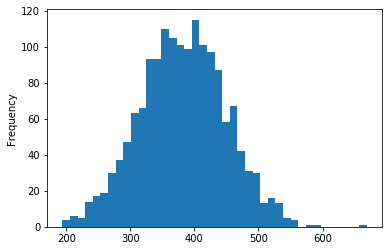

In [23]:
X_train_lengths = list(map(lambda x: len(x.split()), X_train))
df = pd.DataFrame({'counts': X_train_lengths})
df.counts.plot.hist(bins=40)

In [24]:
X1 = np.array(['germany to meet with france'])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=9)
print("X1 = ", X1)
print("X1_indices = ", X1_indices)

X1 =  ['germany to meet with france']
X1_indices =  [[160180 360915 239785 388711 152927      0      0      0      0]]


In [25]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
embedding_layer.get_weights()[0][word_to_index['the']]

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [27]:
print('Build model....')
model = Sequential([
    pretrained_embedding_layer(word_to_vec_map, word_to_index),
    GRU(128, dropout=0.2, return_sequences=True),
    GRU(128, dropout=0.2),
    Dense(1, activation='sigmoid')
])
# model.load_weights('./embedding_model.h5')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model....
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          20000050  
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         69120     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 20,168,371
Trainable params: 168,321
Non-trainable params: 20,000,050
_________________________________________________________________


In [28]:
maxlen = 500
batch_size = 32
X_train_indices = sentences_to_indices(X_train, word_to_index, maxlen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxlen)

In [29]:
Y_train = y_train.reshape((-1, 1))
Y_test = y_test.reshape((-1, 1))

In [30]:
print('Train...')
history = model.fit(X_train_indices, Y_train, batch_size=batch_size, 
                    epochs=10, validation_data=(X_test_indices, Y_test))
model.save('./embedding_model.h5')
score, acc = model.evaluate(X_test_indices, Y_test, 
                           batch_size=batch_size)
print('Test score: ', score)
print('Test accuracy: ', acc)


Train...
Train on 1591 samples, validate on 398 samples
Epoch 1/10
1591/1591 [==============================] - 133s 84ms/sample - loss: 0.6944 - accuracy: 0.5236 - val_loss: 0.6966 - val_accuracy: 0.5050
Epoch 2/10
1591/1591 [==============================] - 120s 75ms/sample - loss: 0.6891 - accuracy: 0.5462 - val_loss: 0.6923 - val_accuracy: 0.5101
Epoch 3/10
1591/1591 [==============================] - 120s 76ms/sample - loss: 0.6860 - accuracy: 0.5512 - val_loss: 0.6957 - val_accuracy: 0.5075
Epoch 4/10
1591/1591 [==============================] - 121s 76ms/sample - loss: 0.6844 - accuracy: 0.5481 - val_loss: 0.6947 - val_accuracy: 0.5050
Epoch 5/10
1591/1591 [==============================] - 111s 70ms/sample - loss: 0.6824 - accuracy: 0.5544 - val_loss: 0.6949 - val_accuracy: 0.5075
Epoch 6/10
1591/1591 [==============================] - 114s 72ms/sample - loss: 0.6737 - accuracy: 0.5525 - val_loss: 0.7062 - val_accuracy: 0.5075
Epoch 7/10
1591/1591 [============================

Test score:  0.7112057643320093
Test accuracy:  0.50753766


In [31]:
y_pred_keras = model.predict(X_test_indices).ravel()
fpr_keras, tpr_keras, threshold_keras = roc_curve(y_test, y_pred_keras)

In [32]:
auc_keras = auc(fpr_keras, tpr_keras)

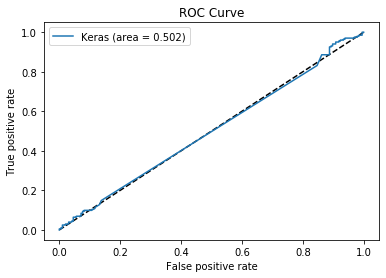

In [33]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label="Keras (area = {:.3f})".format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [34]:
y_pred_keras[0]

0.5302924

In [35]:
X_test[0]

'british man found with nailbomb weapons cache and plans to mass murder immigrants not charged with terrorism israel must give up nuclear weapons united nations resolution ukraine pm discloses accident at nuclear plant reuters russian state tvs latest attempt to persuade viewers of the moral depravity of the west has left it with egg on its face what it presented as a child in the usa being exposed to lewd homoerotica was quickly shown to be a fake pornographic parody taken off the internet dna confirms king richard iiis remains under parking lot an indian state has halted mass sterilisations at health clinics after a doctor was found using a bicycle pump to inflate womens abdomens north korea bans name jongun for all but leader south korean government officials said on wednesday that north korea had banned parents from giving their newborns the same name as the top leader people who already have the name have been ordered to register with new ones president bashar al assad of syria sa